# Unit Test 2

Topics covered:

* Logistic Regression
* Resampling Methods
* Subset Selection
* Shrinkage Methods

## Background
The study of Near-Earth Objects (NEOs) is critical to ensuring future planetary security from impacts by asteroids. Predicting potential impacts may seem as if it is a straightforward task but the number of variables involved in the process leads to quite a bit of uncertainty. Because of this, the Center for NEO Studies (https://cneos.jpl.nasa.gov/about/cneos.html) and NASA's Jet Propulsion Laboratory has been logging data about asteroids and whether they meet the classification of hazardous or not. The data is provided on Canvas.

### Dataset
`nasa.csv`

## Task
Your goal is to construct a model that effectively predicts whether an asteroid is hazardous or not. Ideally, you will find a relatively simple (i.e. interpretable) model, such that we don't need to collect every variable below to make a prediction (hint: subset selection and/or shrinkage would be useful for this). The fewer variables we have to collect, the more asteroids we'll be able to observe. I would also like you to utilize PCA to select some number of principal components and try a logistic regression with those as predictor variables.

I'm looking for a well-constructed logistic regression, whose assumptions have been checked, with strong cross-validated accuracy and an interpretation of the coefficients. 

In [114]:
import os
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
from sklearn.linear_model import RidgeCV
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import mean_squared_error
import datetime as dt
import time
import itertools

cur_dir = Path(os.getcwd()).parent

downloads_path = str(Path.home() / "Downloads")
print(downloads_path)
nasa_df = pd.read_csv( downloads_path + '\\'+ 'nasa.csv')
nasa_df.reset_index(drop=True, inplace=True)

### Dropping Redundant Columns (exp: keeping KM dropping M, Miles, Feet)

nasa_df = nasa_df[['Name', 'Absolute Magnitude', 'Est Dia in KM(min)', 'Est Dia in KM(max)', 'Epoch Date Close Approach', 'Relative Velocity km per hr', 'Miss Dist.(kilometers)', 'Orbit ID', 'Orbit Determination Date', 'Orbit Uncertainity', 'Minimum Orbit Intersection', 'Jupiter Tisserand Invariant', 'Epoch Osculation', 'Eccentricity',	'Semi Major Axis',	'Inclination', 'Asc Node Longitude',	'Orbital Period', 'Perihelion Distance', 'Perihelion Arg',	'Aphelion Dist', 'Perihelion Time', 'Mean Anomaly', 'Mean Motion', 'Hazardous']]

nasa_df.columns = [re.sub(r'\W+', '', column.replace(' ', '_').lower()) for column in nasa_df.columns]
nasa_df.columns = [re.sub(r'(?<![a-zA-Z])_|_(?![a-zA-Z])', '', column) for column in nasa_df.columns]

nasa_df.rename(columns={
    'est_dia_in_kmmin': 'est_dia_in_km(min)',
    'est_dia_in_kmmax': 'est_dia_in_km(max)'
}, inplace=True)

nasa_df['epoch_orbit_determination_date'] = pd.to_datetime(nasa_df['orbit_determination_date']).apply(lambda x: int(x.timestamp()))
nasa_df['hazardous'] = np.where(nasa_df['hazardous'] == True, 1, 0)

### Train, Test, Validation Df
splits = np.random.choice(a = 3, size = nasa_df.shape[0], p = [0.7,0.15,0.15])
nasa_train = nasa_df.iloc[np.where(splits == 0)[0],:]
nasa_val = nasa_df.iloc[np.where(splits == 1)[0],:]
nasa_test = nasa_df.iloc[np.where(splits == 2)[0],:]

train_df = nasa_train
validation_df = nasa_val


test_df = nasa_test[['absolute_magnitude', 'est_dia_in_km(max)', 'epoch_date_close_approach',
       'relative_velocity_km_per_hr', 'miss_distkilometers', 'orbit_id',
       'epoch_orbit_determination_date', 'orbit_uncertainity',
       'minimum_orbit_intersection', 'jupiter_tisserand_invariant',
       'epoch_osculation', 'eccentricity', 'semi_major_axis', 'inclination',
       'asc_node_longitude', 'orbital_period', 'perihelion_distance',
       'perihelion_arg', 'aphelion_dist', 'perihelion_time', 'mean_anomaly',
       'mean_motion', 'hazardous']]

Xtrain = train_df[['absolute_magnitude', 'est_dia_in_km(max)', 'epoch_date_close_approach',
       'relative_velocity_km_per_hr', 'miss_distkilometers', 'orbit_id',
       'epoch_orbit_determination_date', 'orbit_uncertainity',
       'minimum_orbit_intersection', 'jupiter_tisserand_invariant',
       'epoch_osculation', 'eccentricity', 'semi_major_axis', 'inclination',
       'asc_node_longitude', 'orbital_period', 'perihelion_distance',
       'perihelion_arg', 'aphelion_dist', 'perihelion_time', 'mean_anomaly',
       'mean_motion']]

Xtrain = (Xtrain-Xtrain.mean())/Xtrain.std()

#Xtrain = pd.get_dummies(data=Xtrain, drop_first=True)
ytrain = train_df[['hazardous']]

corr = (Xtrain[['absolute_magnitude', 'est_dia_in_km(max)', 'epoch_date_close_approach',
       'relative_velocity_km_per_hr', 'miss_distkilometers', 'orbit_id',
       'epoch_orbit_determination_date', 'orbit_uncertainity',
       'minimum_orbit_intersection', 'jupiter_tisserand_invariant',
       'epoch_osculation', 'eccentricity', 'semi_major_axis', 'inclination',
       'asc_node_longitude', 'orbital_period', 'perihelion_distance',
       'perihelion_arg', 'aphelion_dist', 'perihelion_time', 'mean_anomaly',
       'mean_motion']]).corr()
corr.style.background_gradient(cmap='RdBu')
#
# fig, ax = plt.subplots()
# sns.heatmap((nasa_df[['absolute_magnitude', 'est_dia_in_km(min)',
#        'est_dia_in_km(max)', 'epoch_date_close_approach',
#        'relative_velocity_km_per_hr', 'miss_distkilometers', 'orbit_id',
#        'orbit_determination_date', 'orbit_uncertainity',
#        'minimum_orbit_intersection', 'jupiter_tisserand_invariant',
#        'epoch_osculation', 'eccentricity', 'semi_major_axis', 'inclination',
#        'asc_node_longitude', 'orbital_period', 'perihelion_distance',
#        'perihelion_arg', 'aphelion_dist', 'perihelion_time', 'mean_anomaly',
#        'mean_motion']]).corr(), annot=True, fmt='.2f',
#             cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
# ax.set_yticklabels(ax.get_yticklabels(), rotation='horizontal')
# plt.savefig('infograph.png', bbox_inches='tight')

C:\Users\chance.gunter\Downloads


,absolute_magnitude,est_dia_in_km(max),epoch_date_close_approach,relative_velocity_km_per_hr,miss_distkilometers,orbit_id,epoch_orbit_determination_date,orbit_uncertainity,minimum_orbit_intersection,jupiter_tisserand_invariant,epoch_osculation,eccentricity,semi_major_axis,inclination,asc_node_longitude,orbital_period,perihelion_distance,perihelion_arg,aphelion_dist,perihelion_time,mean_anomaly,mean_motion
absolute_magnitude,1.000000,-0.582742,0.186558,-0.382512,-0.347367,-0.568826,-0.066348,0.674766,-0.493206,0.240402,-0.120221,-0.369316,-0.216776,-0.459408,0.008714,-0.211188,0.094219,0.049004,-0.262234,-0.120884,-0.035804,0.196052
est_dia_in_km(max),-0.582742,1.000000,-0.103985,0.220843,0.176981,0.712254,0.088386,-0.369976,0.243804,-0.121797,0.057440,0.201719,0.111615,0.235783,0.030888,0.108504,-0.069670,-0.029810,0.140363,0.058019,0.016771,-0.094373
epoch_date_close_approach,0.186558,-0.103985,1.000000,-0.114127,-0.158939,-0.096957,-0.049994,0.223411,-0.033058,-0.134026,-0.028977,0.007395,0.135731,-0.087886,-0.023044,0.131130,0.131955,-0.010406,0.115974,-0.030492,-0.031225,-0.139853
relative_velocity_km_per_hr,-0.382512,0.220843,-0.114127,1.000000,0.351579,0.099875,0.060463,-0.197681,0.089271,-0.051435,0.013433,0.502886,0.016532,0.532823,-0.019140,0.020887,-0.512368,0.000691,0.147568,0.015113,0.018358,0.026050
miss_distkilometers,-0.347367,0.176981,-0.158939,0.351579,1.000000,0.142031,0.044752,-0.316398,0.363306,0.097804,0.189552,-0.006741,-0.111926,0.280009,-0.038088,-0.108751,-0.077973,-0.035246,-0.103422,0.186454,-0.014646,0.110570
orbit_id,-0.568826,0.712254,-0.096957,0.099875,0.142031,1.000000,0.072989,-0.493211,0.124918,-0.011615,0.033725,0.096037,0.001114,0.101071,0.033749,-0.001140,-0.066130,-0.012933,0.017925,0.035479,0.034703,-0.001268
epoch_orbit_determination_date,-0.066348,0.088386,-0.049994,0.060463,0.044752,0.072989,1.000000,-0.081476,0.017130,-0.003100,0.124053,0.023673,-0.031160,0.022408,0.031692,-0.045447,-0.038089,0.002315,-0.024656,0.121252,-0.012970,-0.002564
orbit_uncertainity,0.674766,-0.369976,0.223411,-0.197681,-0.316398,-0.493211,-0.081476,1.000000,-0.269669,-0.011065,-0.338196,-0.095231,0.042876,-0.221873,0.015345,0.046462,0.115058,0.034497,0.018107,-0.334062,-0.051068,-0.026949
minimum_orbit_intersection,-0.493206,0.243804,-0.033058,0.089271,0.363306,0.124918,0.017130,-0.269669,1.000000,-0.303642,0.080425,0.102826,0.285684,0.440875,-0.017477,0.276165,0.285183,-0.042787,0.242221,0.082691,-0.015152,-0.287297
jupiter_tisserand_invariant,0.240402,-0.121797,-0.134026,-0.051435,0.097804,-0.011615,-0.003100,-0.011065,-0.303642,1.000000,0.047501,-0.483287,-0.930041,-0.038729,0.034600,-0.892625,-0.532328,0.059282,-0.888568,0.045903,0.023097,0.992538


Text(0.5, 1.0, 'Scree Plot')

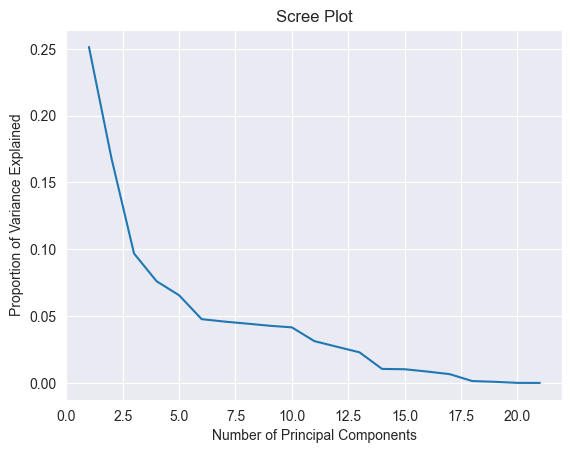

In [115]:
pca = PCA(n_components=Xtrain.shape[1]-1).fit(Xtrain)
pc_train = pca.transform(Xtrain)
sns.lineplot(x=np.arange(1,Xtrain.shape[1]), y=pca.explained_variance_ratio_)
plt.xlabel("Number of Principal Components")
plt.ylabel("Proportion of Variance Explained")
plt.title("Scree Plot")

Text(0, 0.5, 'Cumulative Proportion of Variance Explained')

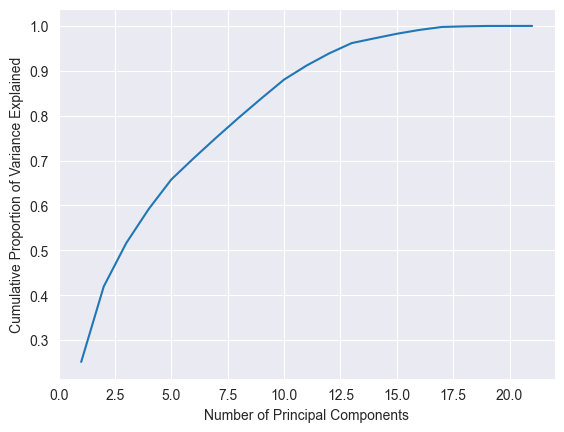

In [116]:
sns.lineplot(x=np.arange(1,Xtrain.shape[1]), y=np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Proportion of Variance Explained")

Text(0, 0.5, 'Cumulative Proportion of Variance Explained')

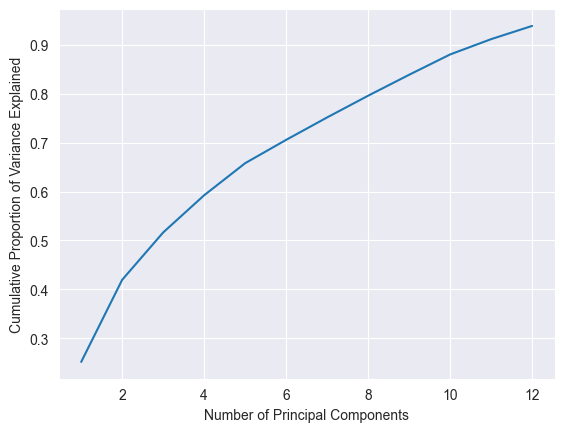

In [117]:
pca = PCA(n_components=12).fit(Xtrain)
pc_train = pca.transform(Xtrain)
sns.lineplot(x=np.arange(1,13), y=np.cumsum(pca.explained_variance_ratio_)[:12])
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Proportion of Variance Explained")

In [118]:

pc_log_reg = LogisticRegressionCV().fit(pc_train[:,:12],ytrain.iloc[:])
pc_train_df = pd.DataFrame(pc_train[:,:12])
pc_test = pca.transform(test_df.iloc[:,:-1])
pc_log_reg.score(pc_test[:,:12], test_df.iloc[:,22])

C:\Users\chance.gunter\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8120617110799438

In [119]:
ridgecv = RidgeCV(alphas=np.linspace(.01, 700,100000), scoring='neg_mean_squared_error', store_cv_values=True, cv=None)
ridgecv.fit(pc_train_df, ytrain)
print(ridgecv.alpha_)
print(ridgecv.cv_values_)
print(ridgecv.coef_)
print(ridgecv.best_score_)

334.4615666156662
[[[ 0.02695855  0.02695853  0.0269585  ...  0.02420687  0.02420684
    0.02420681]]

 [[-0.05033156 -0.05033142 -0.05033127 ... -0.03831293 -0.03831283
   -0.03831273]]

 [[-0.09750394 -0.09750385 -0.09750376 ... -0.09028935 -0.09028929
   -0.09028923]]

 ...

 [[-0.04741128 -0.04741131 -0.04741134 ... -0.04924067 -0.04924068
   -0.04924069]]

 [[-0.25601336 -0.256013   -0.25601265 ... -0.22514853 -0.22514826
   -0.22514799]]

 [[-0.21562455 -0.21562392 -0.2156233  ... -0.16609129 -0.16609089
   -0.16609049]]]
[[ 0.00281904  0.04318001  0.0266623  -0.03390819  0.07470982  0.00510761
   0.01500446  0.01313734 -0.03045332 -0.00333695  0.00849703 -0.02990603]]
-0.10950035787089703


In [120]:
def processSubset(X, y, predictor_variables, response_variable):
    X_subset = X[list(predictor_variables)].reset_index(drop=True)
    y_subset = y[response_variable].reset_index(drop=True)

    model = sm.OLS(y_subset, X_subset)
    regr = model.fit()
    RSS = ((regr.predict(X_subset) - y_subset) ** 2).sum()

    return {"model": regr, "RSS": RSS}



def getBest(X, y, k, response_variable):
    t0 = time.time()
    results = []

    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(X, y, combo, response_variable))

    models = pd.DataFrame(results)

    best_model = models.loc[models['RSS'].argmin()]
    t1 = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (t1-t0), "seconds.")

    return best_model

models_best = pd.DataFrame(columns=["RSS", "model"])

t2 = time.time()
for i in range(1,int(pc_train_df.shape[1]) + 1):
    models_best.loc[i] = getBest(pc_train_df, ytrain, i, 'hazardous')

t3 = time.time()
print("Total elapsed time:", (t3-t2), "seconds.")

result_obj = models_best.loc[12, 'model']  # Assuming 'row_index' and 'column_name' specify the location of the object in the DataFrame

stored_value = result_obj.params if isinstance(result_obj, sm.regression.linear_model.RegressionResultsWrapper) else result_obj

print('\n')
print(stored_value)

Processed 12 models on 1 predictors in 0.027926921844482422 seconds.
Processed 66 models on 2 predictors in 0.12668848037719727 seconds.
Processed 220 models on 3 predictors in 0.4598715305328369 seconds.
Processed 495 models on 4 predictors in 1.1500978469848633 seconds.
Processed 792 models on 5 predictors in 1.9107677936553955 seconds.
Processed 924 models on 6 predictors in 3.0619864463806152 seconds.
Processed 792 models on 7 predictors in 2.7665042877197266 seconds.
Processed 495 models on 8 predictors in 1.6337883472442627 seconds.
Processed 220 models on 9 predictors in 0.9446916580200195 seconds.
Processed 66 models on 10 predictors in 0.29462575912475586 seconds.
Processed 12 models on 11 predictors in 0.05481266975402832 seconds.
Processed 1 models on 12 predictors in 0.006316423416137695 seconds.
Total elapsed time: 12.577714204788208 seconds.


0     0.002871
1     0.044370
2     0.027937
3    -0.035971
4     0.079986
5     0.005603
6     0.016517
7     0.014507
8    -0.03

C:\Users\chance.gunter\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Optimization terminated successfully.
         Current function value: 0.342508
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342508
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342508
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342508
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342508
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342508
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342508
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342508
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342508
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342508
  

0.8120617110799438

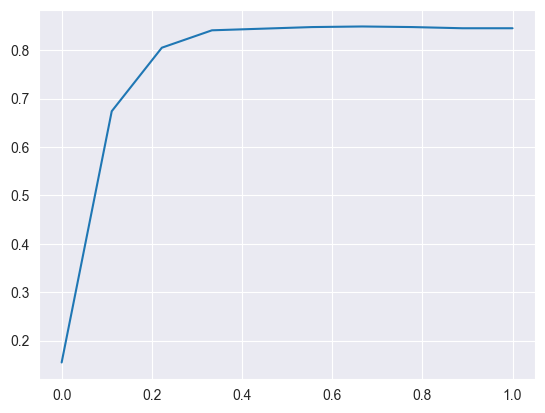

In [130]:
preds = LogisticRegressionCV(cv=10).fit(pc_train[:,:12],ytrain.iloc[:])
preds = preds.predict(pc_test)
thresholds = np.linspace(0,1,10)
acc_list = []

folds = np.random.choice(a = 10, size = pc_train_df.shape[0])

t0 = time.time()
for thresh in thresholds:
    bin_pred_list = []
    yval_list = []
    for i in range(10):
        val = pc_train_df.iloc[np.where(folds == i)[0],:]
        train = pc_train_df.iloc[np.where(folds != i)[0],:]

        pc_train_df = sm.add_constant(pc_train_df)

        ytrain.reset_index(drop=True, inplace=True)
        pc_train_df.reset_index(drop=True, inplace=True)

        log_reg = sm.Logit(ytrain, pc_train_df).fit()

        val_preds = log_reg.predict(pc_train_df.apply(pd.to_numeric))

        binary_preds = np.where(val_preds >= thresh, 1, 0)
        bin_pred_list.extend(binary_preds)
        yval_list.extend(ytrain['hazardous'].tolist())
    acc_list.append(accuracy_score(yval_list, bin_pred_list))
t1 = time.time()

plt.plot(thresholds, acc_list)
print(thresholds[np.argmax(acc_list)])
binary_preds = np.where(preds >= thresholds[np.argmax(acc_list)], 1, 0)

accuracy_score(test_df['hazardous'], binary_preds)